In [1]:
import sys
sys.path.append("/home/users/joytzphysics/Analysis/abcdnet/python")

In [2]:
import torch
import os
import glob
import uproot
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import json

In [3]:
import models
from python.utils import VBSConfig, print_title
from python.losses import SingleDisCoLoss
from python.datasets import DisCoDataset
from python.singledisco.train import get_outfile
import ingress

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"use_cuda: {use_cuda}")

use_cuda: False


In [5]:
config=VBSConfig.from_json("configs/ABCDNet_VBSVVHSingleDisco.json")
test_datapath=ingress.get_outfile(config, tag="test")
val_datapath=ingress.get_outfile(config,tag="val")
train_datapath=ingress.get_outfile(config,tag="train")
print(test_datapath)
print(val_datapath)
print(train_datapath)

/home/users/joytzphysics/Analysis/abcdnet/ABCDNet_VBSVVHSingleDisco/datasets/ABCDNet_VBSVVHSingleDisco_test.pt
/home/users/joytzphysics/Analysis/abcdnet/ABCDNet_VBSVVHSingleDisco/datasets/ABCDNet_VBSVVHSingleDisco_val.pt
/home/users/joytzphysics/Analysis/abcdnet/ABCDNet_VBSVVHSingleDisco/datasets/ABCDNet_VBSVVHSingleDisco_train.pt


In [6]:
history=get_outfile(config,tag="history",ext="json")
print(history)
with open(history) as f:
    history_data = json.load(f)
print(history_data.keys())

/home/users/joytzphysics/Analysis/abcdnet/ABCDNet_VBSVVHSingleDisco/ABCDNet_VBSVVHSingleDisco_modelNeuralNetwork_nhidden3_hiddensize128_lr0.001_discolambda5_history.json
dict_keys(['train_loss', 'test_loss', 'test_acc'])


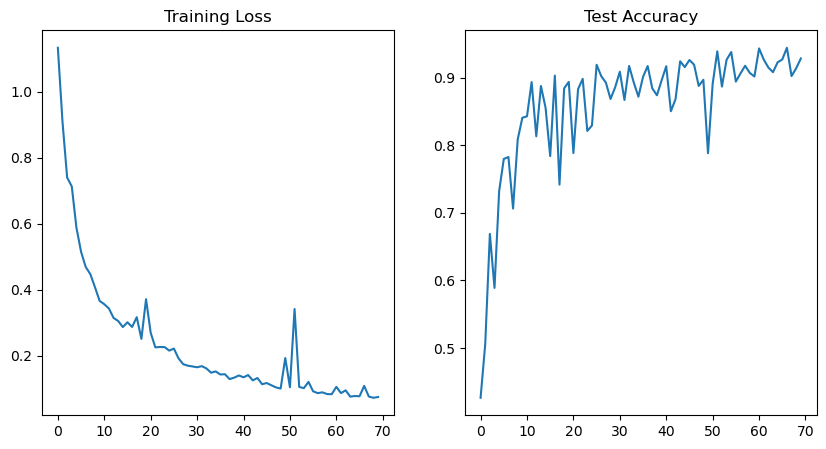

In [7]:
import matplotlib.pyplot as plt

# Assuming 'train_loss' and 'test_accuracy' are lists of float values
train_loss = history_data['test_loss']
test_accuracy = history_data['test_acc']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot training loss on the first subplot
ax1.plot(train_loss)
ax1.set_title('Training Loss')

# Plot test accuracy on the second subplot
ax2.plot(test_accuracy)
ax2.set_title('Test Accuracy')

# Show the plots
plt.show()

In [8]:
model_path=get_outfile(config, epoch=70, tag="model")
Model=getattr(models, config.model.name)
model=Model.from_config(config).to(device)

----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [9]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [10]:
test_data=DisCoDataset.from_files(
    test_datapath,
    is_single_disco=(config.ingress.get("disco_target", None) != None)
)

In [11]:
test_loader = DataLoader(test_data, batch_size=1000000, shuffle=True)

In [15]:
y_pred_list = []
y_true_list = []
x_list=[]
target_list=[]

model.eval()
with torch.no_grad():
    for batch_i, (features, labels, weights, disco_target) in enumerate(test_loader):
        # Load data
        output = model(features)
        x_list.append(features.cpu().numpy())
        y_pred_list.append(output.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())
        target_list.append(disco_target.cpu().numpy())

predicted_scores = np.concatenate(y_pred_list)
true_labels = np.concatenate(y_true_list)
inputs = np.concatenate(x_list, axis=0)
target = np.concatenate(target_list)

In [14]:
print(inputs.shape)
print(predicted_scores.shape)
print(true_labels.shape)
print(target.shape)

(74833, 22)
(74833, 1)
(74833,)
(74833,)


In [15]:
plots_dir=f"{config.basedir}/{config.name}/plots/lambda{config.train.disco_lambda}_scatter"
os.makedirs(plots_dir,exist_ok=True)

In [16]:
label_dict={
    'hbb_pt': r'$p_T(H\to bb)$',
    'hbb_eta': r'$\eta(H\to bb)$',
    'hbb_phi': r'$\phi(H\to bb)$',
    'hbb_mass': r'$M(H\to bb)$',
    'ld_vbfjet_phi': r'$\phi(VBF_{ld})$',
    'ld_vbfjet_mass': r'$M(VBF_{ld})$',
    'ld_vbfjet_eta': r'$\eta(VBF_{ld})$',
    'ld_vbfjet_pt': r'$p_T(VBF_{ld})$',
    'sd_vbfjet_phi': r'$\phi(VBF_{sd})$',
    'sd_vbfjet_mass': r'$M(VBF_{sd})$',
    'sd_vbfjet_eta': r'$\eta(VBF_{sd})$',
    'sd_vbfjet_pt': r'$p_T(VBF_{sd})$',
    'ld_lep_phi':r'$\phi(lep_{ld})$',
    'ld_lep_eta':r'$\eta(lep_{ld})$',
    'ld_lep_mass':r'$M(lep_{ld})$',
    'ld_lep_pt':r'$p_T(lep_{ld})$',
    'sd_lep_phi':r'$\phi(lep_{sd})$',
    'sd_lep_eta':r'$\eta(lep_{sd})$',
    'sd_lep_mass':r'$M(lep_{sd})$',
    'sd_lep_pt':r'$p_T(lep_{sd})$',
    'mjj':r'$M_{jj}$',
    'detajj':r'$\Delta \eta_{jj}$'
}

/tmp/ipykernel_2881553/82053257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


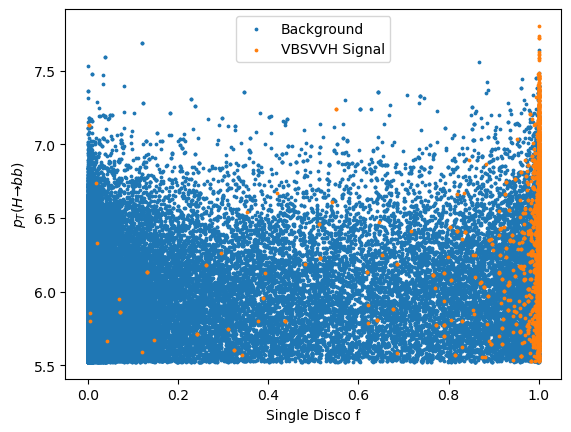

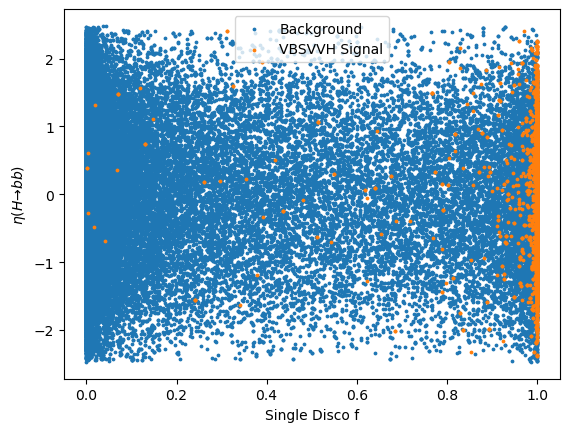

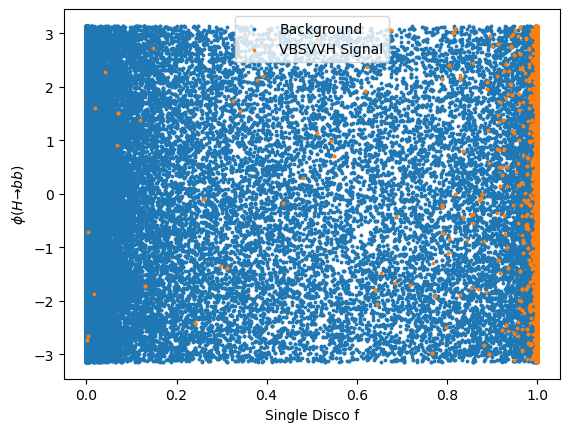

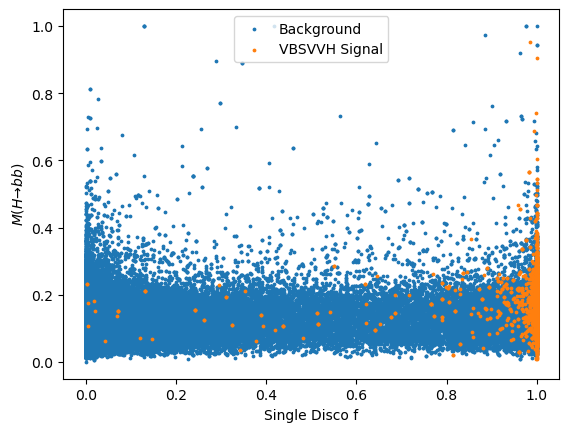

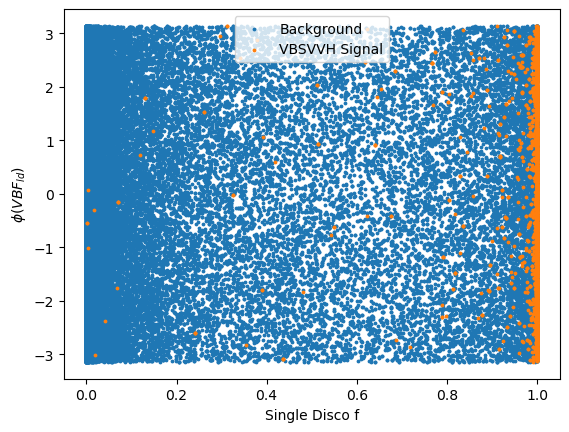

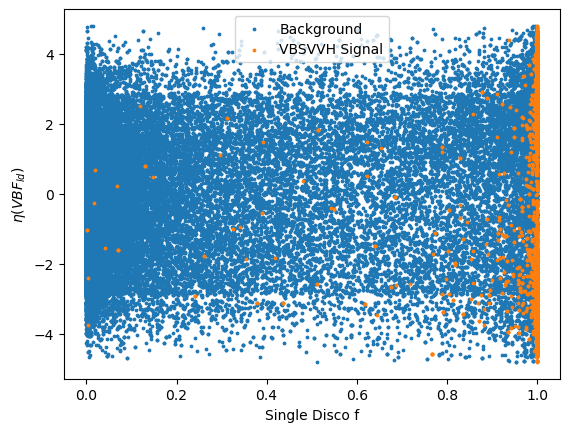

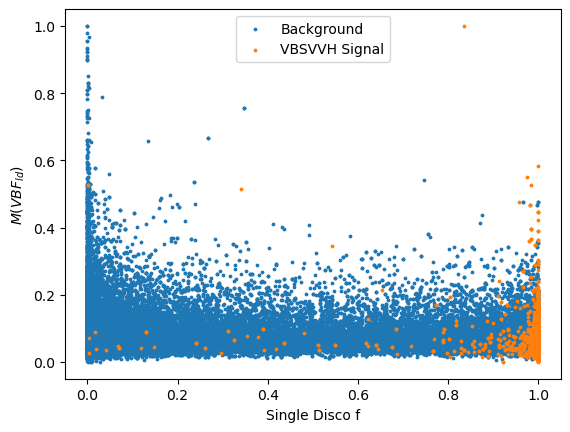

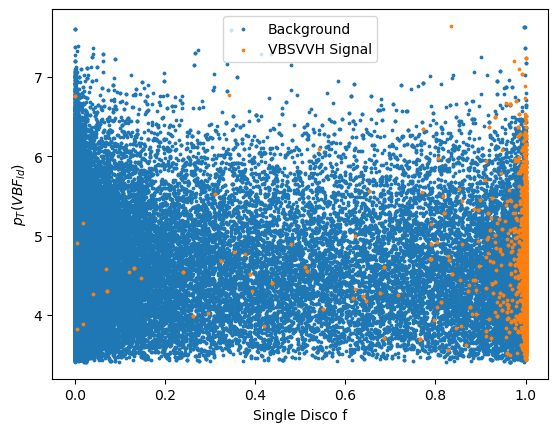

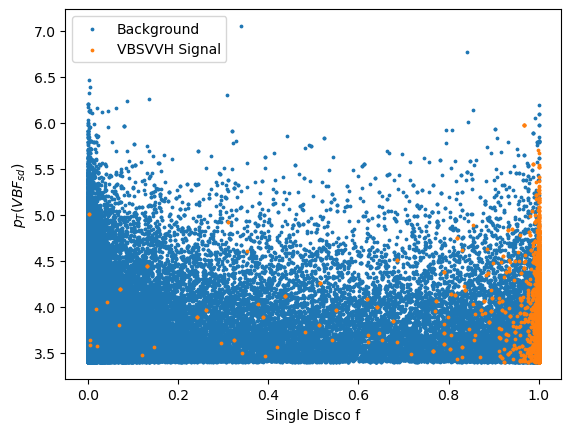

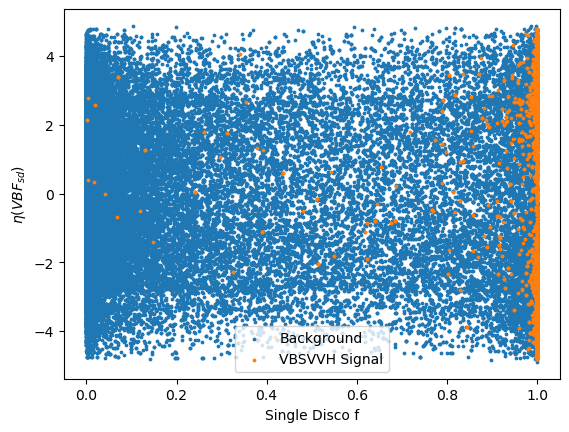

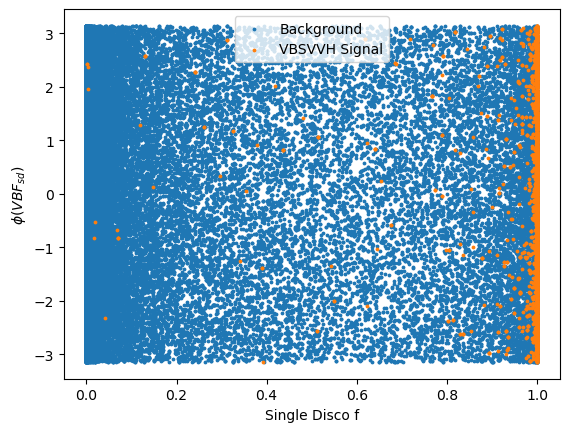

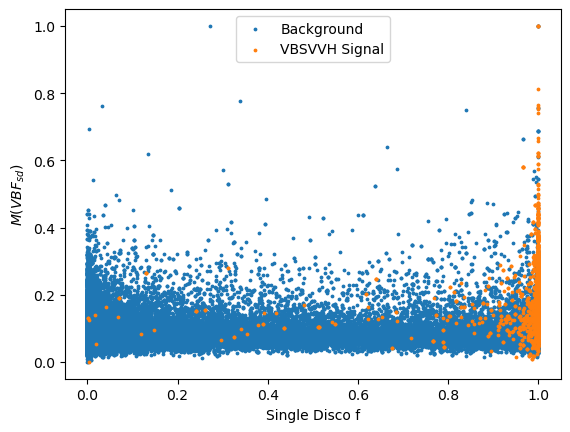

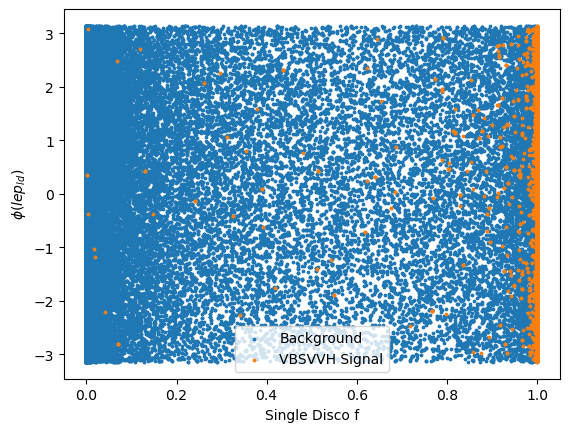

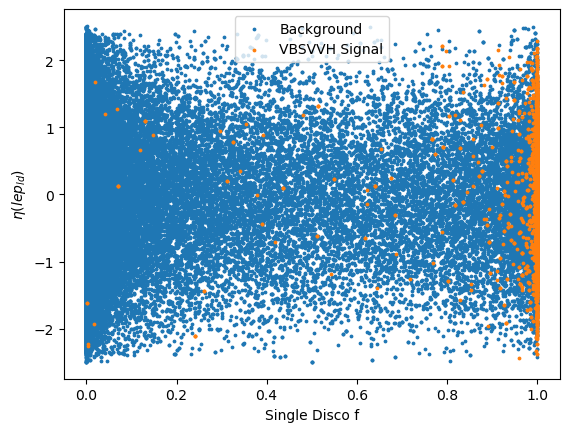

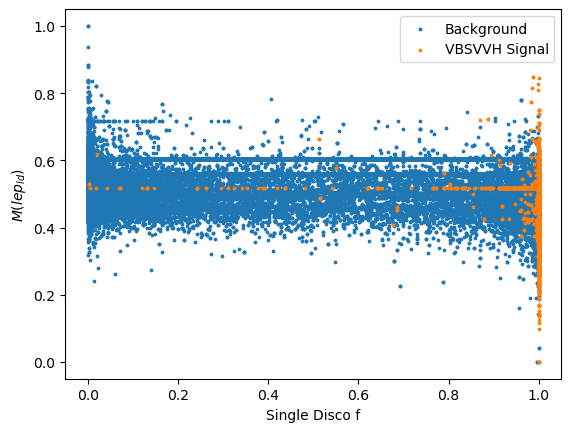

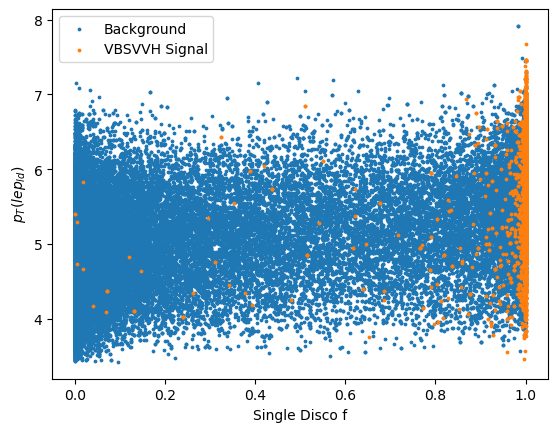

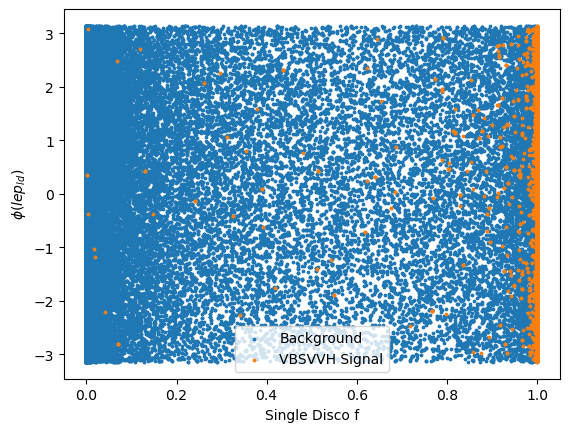

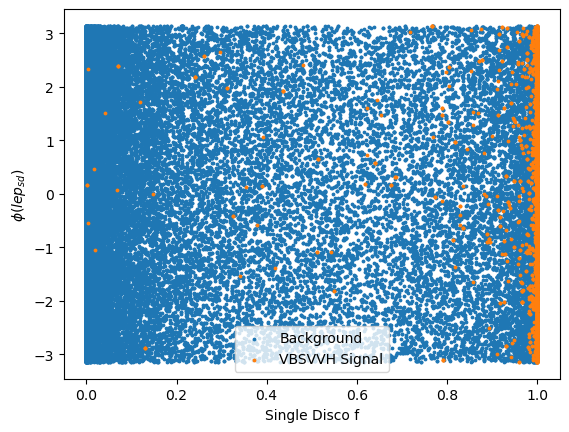

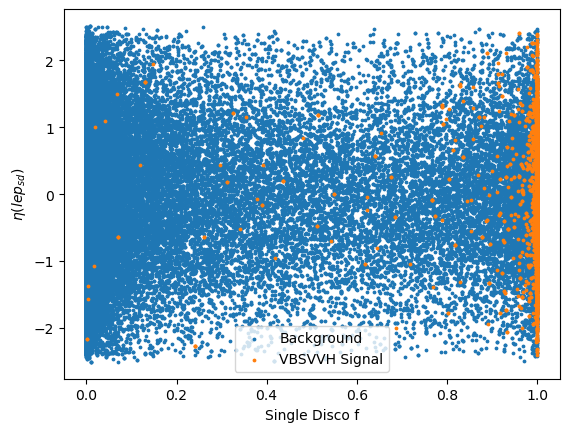

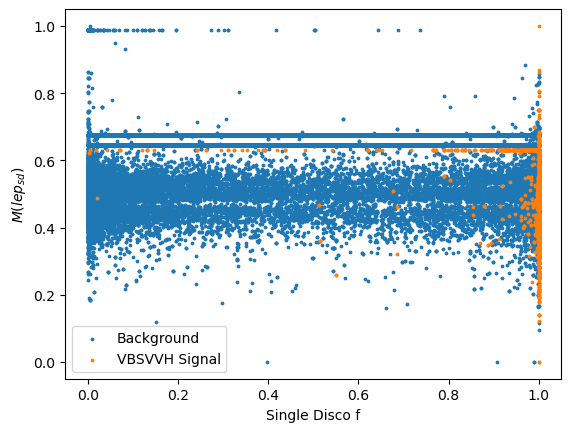

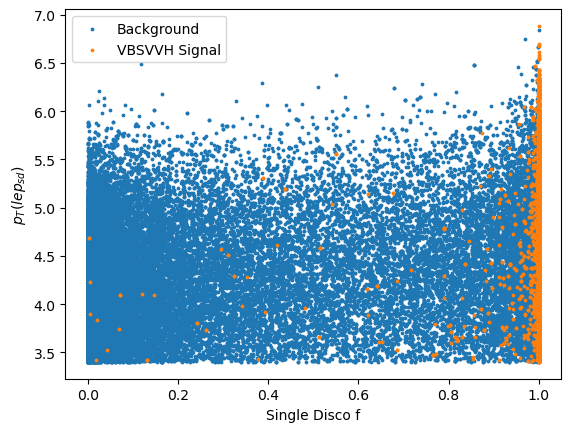

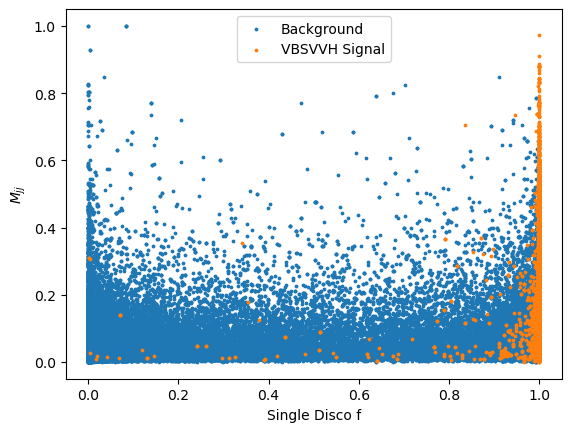

In [17]:
input_names=config.ingress.features
# scatter plots of classifiers versus input features for background and signal separately
for idx, name in enumerate(input_names):
    plt.figure()
    plt.scatter(predicted_scores[:,0][true_labels==0], inputs[:,idx][true_labels==0], s=3, label='Background')
    plt.scatter(predicted_scores[:,0][true_labels==1], inputs[:,idx][true_labels==1], s=3, label='VBSVVH Signal')
    plt.xlabel('Single Disco f')
    if name in label_dict: 
        plt.ylabel(label_dict[name])
    else:
        plt.ylabel(name)
    plt.legend()
    plt.savefig(f'{plots_dir}/disco{config.train.disco_lambda}_{name}.png')

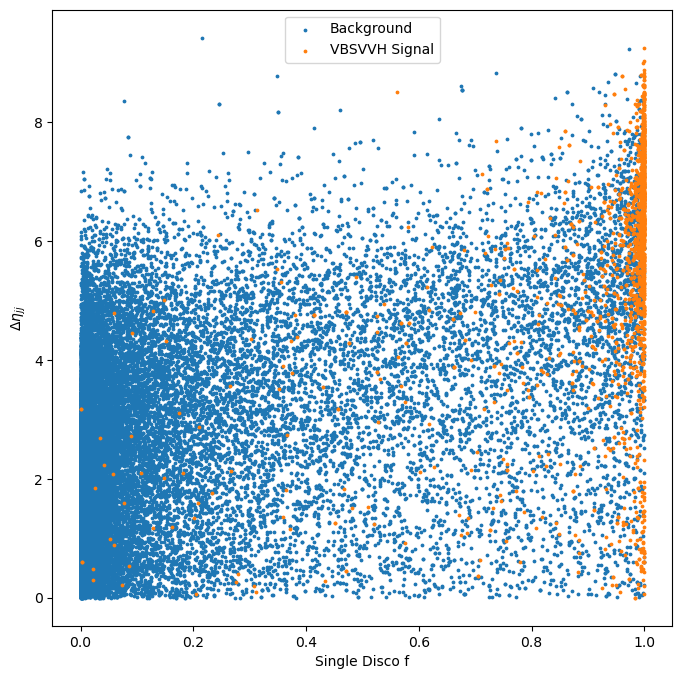

In [ ]:
disco_name=config.ingress.disco_target
plt.figure(figsize=(8,8))
plt.scatter(predicted_scores[:,0][true_labels==0], target[true_labels==0], s=3, label='Background')
plt.scatter(predicted_scores[:,0][true_labels==1], target[true_labels==1], s=3, label='VBSVVH Signal')
plt.xlabel('Single Disco f')
if disco_name in label_dict: 
    plt.ylabel(label_dict[disco_name])
else:
    plt.ylabel(disco_name)
plt.legend()
plt.savefig(f'{plots_dir}/lambda{config.train.disco_lambda}_{disco_name}.png')

<Axes: >

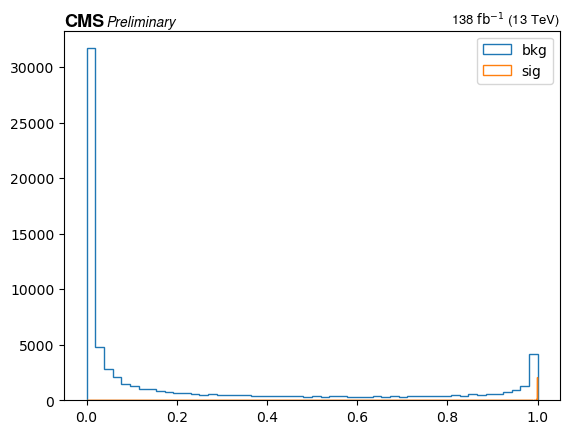

In [22]:
import yahist as yh
from yahist import Hist1D
import mplhep as hep
fig, axes=plt.subplots()
hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes)
bkg_hist=Hist1D(predicted_scores[:,0][true_labels==0], label="bkg")
sig_hist=Hist1D(predicted_scores[:,0][true_labels==1], label='sig')
bkg_hist.plot()
sig_hist.plot()

In [ ]:
public_html_dir="/home/users/joytzphysics/public_html/abcdnet"
os.makedirs(f'{public_html_dir}/VBSVVH/lambda{config.train.disco_lambda}/scatter_plots',exist_ok=True)

In [ ]:
import shutil
shutil.copytree(plots_dir,f'{public_html_dir}/VBSVVH/lambda{config.train.disco_lambda}/scatter_plots', dirs_exist_ok=True)

'/home/users/joytzphysics/public_html/abcdnet/VBSVVH/scatter_plots'

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)

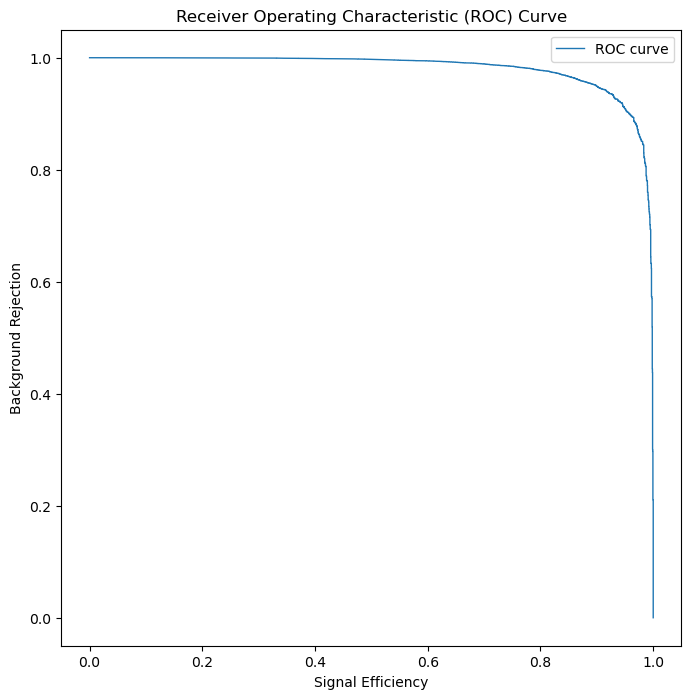

In [21]:
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8, 8))
plt.plot(tpr, 1-fpr, lw=1, label='ROC curve')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [ ]:
roc_auc

0.8735077795578413